In [1]:
import pandas as pd
import numpy as np
import os
import typing as tp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(rc={'figure.figsize': (8.25, 5.875), 'figure.dpi': 100, 'axes.labelpad': 2, 'savefig.pad_inches': .5})

In [2]:
cars_path: str = os.path.join('..', 'data', 'Assign4', 'cars.csv')
df: pd.DataFrame = pd.read_csv(cars_path)
df

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,...,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Subaru,Outback,automatic,silver,190000,2010,gasoline,False,gasoline,2.5,...,True,True,True,False,True,False,True,True,True,16
1,Subaru,Outback,automatic,blue,290000,2002,gasoline,False,gasoline,3.0,...,True,False,False,True,True,False,False,False,True,83
2,Subaru,Forester,automatic,red,402000,2001,gasoline,False,gasoline,2.5,...,True,False,False,False,False,False,False,True,True,151
3,Subaru,Impreza,mechanical,blue,10000,1999,gasoline,False,gasoline,3.0,...,False,False,False,False,False,False,False,False,False,86
4,Subaru,Legacy,automatic,black,280000,2001,gasoline,False,gasoline,2.5,...,True,False,True,True,False,False,False,False,True,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,Chrysler,300,automatic,silver,290000,2000,gasoline,False,gasoline,3.5,...,True,False,False,True,True,False,False,True,True,301
38527,Chrysler,PT Cruiser,mechanical,blue,321000,2004,diesel,False,diesel,2.2,...,True,False,False,True,True,False,False,True,True,317
38528,Chrysler,300,automatic,blue,777957,2000,gasoline,False,gasoline,3.5,...,True,False,False,True,True,False,False,True,True,369
38529,Chrysler,PT Cruiser,mechanical,black,20000,2001,gasoline,False,gasoline,2.0,...,True,False,False,False,False,False,False,False,True,490


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
# I basically took what I had in Module 5 and copied/pasted it here
# Yes I know doing a binary encoding would be better, but eh

def translate_to_english(belarus_phrase: str) -> str:
    if belarus_phrase == 'Минская обл.':
        return 'Minsk region'
    elif belarus_phrase == 'Гомельская обл.':
        return 'Gomel region'
    elif belarus_phrase == 'Брестская обл.':
        return 'Brest region'
    elif belarus_phrase == 'Могилевская обл.':
        return 'Mogilev region'
    elif belarus_phrase == 'Витебская обл.':
        return 'Vitebsk region'
    elif belarus_phrase == 'Гродненская обл.':
        return 'Grodno region'
    else:
        return 'ERROR'

def onehot_encode_column(df: pd.DataFrame, cols: tp.List[str], prefixes: tp.List[str]) -> tp.Tuple[pd.DataFrame, tp.List[str]]:
    df: pd.DataFrame = df.copy()
    new_columns: tp.List[str] = []
    for column, prefix in zip(cols, prefixes):
        dummies: pd.DataFrame = pd.get_dummies(df[column], prefix=prefix)
        new_columns.extend(dummies.columns)
        df: pd.DataFrame = pd.concat([df, dummies], axis=1)
        df: pd.DataFrame = df.drop(column, axis=1)
    return df, new_columns

def process_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Translate region.
    df['region_english'] = (df['location_region'].map(translate_to_english)
                                        .str.slice(stop=-7))
    onehot_encoded_columns: tp.List[str] = ['manufacturer_name', 'region_english', 'engine_type', 'body_type', 'state']
    onehot_encoded_prefixes: tp.List[str] = ['make', 'region', 'engine type', 'body', 'state']
    df, onehot_new_cols = onehot_encode_column(df, onehot_encoded_columns, onehot_encoded_prefixes)
    df['is_automatic'] = df['transmission'] == 'automatic'
    scraped_year: int = 2019
    df['age_years'] = scraped_year - df['year_produced']
    df['is_all_wheel_drive'] = df['drivetrain'] == 'all'
    df['is_gas'] = df['engine_fuel'].str.startswith('gas')
    boolean_columns: tp.List[str] = ['engine_has_gas', 'has_warranty', 'is_exchangeable', 'is_all_wheel_drive', 'is_automatic', 'is_gas']
    df[boolean_columns] = df[boolean_columns].astype(np.int8)
    return df

def drop_columns(df: pd.DataFrame) -> pd.DataFrame:
    bad_feature_names: tp.List[str] = [f'feature_{i}' for i in range(10)]
    irrelevant_columns: tp.List[str] = ['number_of_photos', 'up_counter', 'duration_listed', 'model_name', 'color']
    processed_columns: tp.List[str] = ['location_region', 'drivetrain', 'transmission', 'year_produced', 'engine_fuel']
    columns_to_drop: tp.List[str] = bad_feature_names + irrelevant_columns + processed_columns
    df = df.drop(columns_to_drop, axis=1)
    return df

In [5]:
def process_all_things(df: pd.DataFrame) -> pd.DataFrame:
    df: pd.DataFrame = process_columns(df)
    df: pd.DataFrame = drop_columns(df)
    return df.dropna()

In [6]:
processed_df: pd.DataFrame = process_all_things(df)
processed_df

,odometer_value,engine_has_gas,engine_capacity,has_warranty,price_usd,is_exchangeable,make_Acura,make_Alfa Romeo,make_Audi,make_BMW,...,body_suv,body_universal,body_van,state_emergency,state_new,state_owned,is_automatic,age_years,is_all_wheel_drive,is_gas
0,190000,0,2.5,0,10900.00,0,0,0,0,0,...,0,1,0,0,0,1,1,9,1,1
1,290000,0,3.0,0,5000.00,1,0,0,0,0,...,0,1,0,0,0,1,1,17,1,1
2,402000,0,2.5,0,2800.00,1,0,0,0,0,...,1,0,0,0,0,1,1,18,1,1
3,10000,0,3.0,0,9999.00,1,0,0,0,0,...,0,0,0,0,0,1,0,20,1,1
4,280000,0,2.5,0,2134.11,1,0,0,0,0,...,0,1,0,0,0,1,1,18,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38526,290000,0,3.5,0,2750.00,1,0,0,0,0,...,0,0,0,0,0,1,1,19,0,1
38527,321000,0,2.2,0,4800.00,1,0,0,0,0,...,0,0,0,0,0,1,0,15,0,0
38528,777957,0,3.5,0,4300.00,0,0,0,0,0,...,0,0,0,0,0,1,1,19,0,1
38529,20000,0,2.0,0,4000.00,1,0,0,0,0,...,0,0,0,0,0,1,0,18,0,1


In [7]:
X: np.ndarray = processed_df.values

In [33]:
results: tp.List[tp.Dict[str, tp.Union[str, int, float]]] = []

max_k: int = int(max([np.log2(X.shape[0]), X.shape[0] ** .5, 75]))

print(f'Going to {max_k} number of clusters...')

for k in range(2, max_k):
    print(f'Doing k={k}...')
    model = KMeans(n_clusters=k, random_state=13)

    model.fit(X)

    silhouette: float = silhouette_score(X, model.labels_, random_state=13)

    results.append({'k': k, 'inertia': model.inertia_, 'cluster_centers': model.cluster_centers_, 'silhouette': silhouette})

results_df: pd.DataFrame = pd.DataFrame.from_records(results)
results_df

Going to 196 number of clusters...
Doing k=2...
Doing k=3...
Doing k=4...
Doing k=5...
Doing k=6...
Doing k=7...
Doing k=8...
Doing k=9...
Doing k=10...
Doing k=11...
Doing k=12...
Doing k=13...
Doing k=14...
Doing k=15...
Doing k=16...
Doing k=17...
Doing k=18...
Doing k=19...
Doing k=20...
Doing k=21...
Doing k=22...
Doing k=23...
Doing k=24...
Doing k=25...
Doing k=26...
Doing k=27...
Doing k=28...
Doing k=29...
Doing k=30...
Doing k=31...
Doing k=32...
Doing k=33...
Doing k=34...
Doing k=35...
Doing k=36...
Doing k=37...
Doing k=38...
Doing k=39...
Doing k=40...
Doing k=41...
Doing k=42...
Doing k=43...
Doing k=44...
Doing k=45...
Doing k=46...
Doing k=47...
Doing k=48...
Doing k=49...
Doing k=50...
Doing k=51...
Doing k=52...
Doing k=53...
Doing k=54...
Doing k=55...
Doing k=56...
Doing k=57...
Doing k=58...
Doing k=59...
Doing k=60...
Doing k=61...
Doing k=62...
Doing k=63...
Doing k=64...
Doing k=65...
Doing k=66...
Doing k=67...
Doing k=68...
Doing k=69...
Doing k=70...
Doing k

,k,inertia,cluster_centers,silhouette
0,2,3.131843e+14,"[[153218.51043902442, 0.025121951219511954, 2....",0.542363
1,3,1.864318e+14,"[[306021.6330774958, 0.04387224560534779, 2.10...",0.554462
2,4,1.078316e+14,"[[871026.4166666671, 0.04523809523809523, 2.09...",0.526540
3,5,6.716216e+13,"[[313857.04215116403, 0.04444614443084455, 2.0...",0.526947
4,6,4.587655e+13,"[[270437.8490255522, 0.03993070593330447, 2.08...",0.522342
...,...,...,...,...
189,191,3.124230e+11,"[[100492.89705882352, 0.014705882352941176, 2....",0.431675
190,192,3.114008e+11,"[[98892.37142857144, 0.01428571428571428, 2.86...",0.431260
191,193,3.094492e+11,"[[98892.37142857144, 0.014285714285714287, 2.8...",0.431557
192,194,3.076566e+11,"[[98892.37142857144, 0.01428571428571428, 2.86...",0.431660


<Figure size 825x587.5 with 0 Axes>

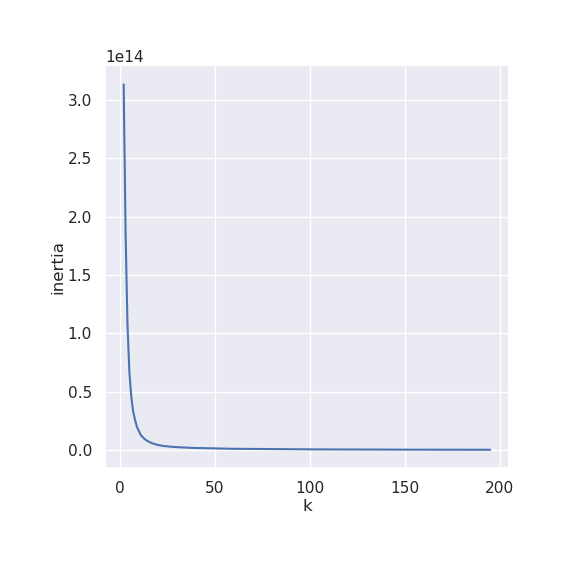

In [34]:
plt.clf()
sns.relplot(data=results_df, x='k', y='inertia', kind='line')
plt.show()

<Figure size 825x587.5 with 0 Axes>

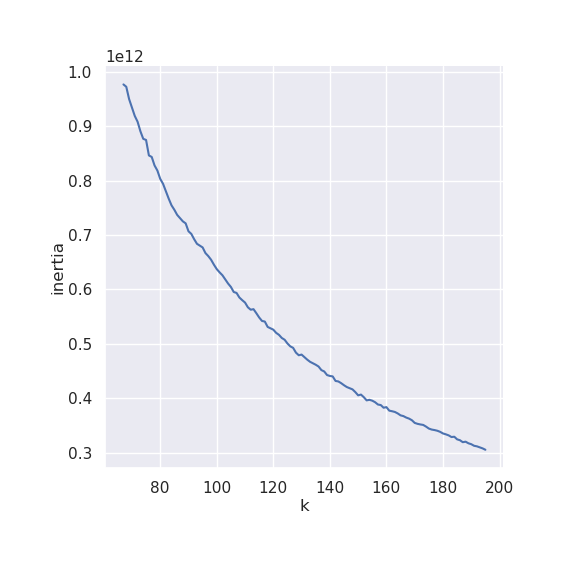

In [37]:
plt.clf()
sns.relplot(data=results_df.query('inertia < 1e12').copy(), x='k', y='inertia', kind='line')
plt.show()

In [36]:
results_df.describe()

,k,inertia,silhouette
count,194.000000,1.940000e+02,194.000000
mean,98.500000,5.396950e+12,0.445974
std,56.147128,2.776179e+13,0.028017
min,2.000000,3.050984e+11,0.420256
25%,50.250000,4.188010e+11,0.428555
50%,98.500000,6.498578e+11,0.437108
75%,146.750000,1.388429e+12,0.445786
max,195.000000,3.131843e+14,0.554462


I'd say that if there *were* going to be classifications, there could be like 20-50ish possible before there's a loss of information.